# Import Required Libraries

In [1]:
WANDB = True
EXP_NAME = "val6-2_effnetb0_focal_loss"
# EXP_NAME = "try"

if WANDB:
    # !pip install wandb
    import wandb
    import os
    from dotenv import load_dotenv
    load_dotenv()
    wandb.login(key=os.environ.get("WANDB_API_KEY"))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: trira7503. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
# !apt-get install -y libgl1-mesa-dev


In [3]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision
# from torcheval.metrics.functional import binary_auroc

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold 
from sklearn.metrics import roc_auc_score

# For Image Models
import timm

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Training Configuration

In [4]:
CONFIG = {
    "seed": 42,
    "epochs": 50,
    # "epochs": 3, #######　後でなおすこと
    "img_size": 384,
    "model_name": "tf_efficientnet_b0_ns",
    "checkpoint_path" : "/kaggle/input/tf-efficientnet/pytorch/tf-efficientnet-b0/1/tf_efficientnet_b0_aa-827b6e33.pth",
    "train_batch_size": 64,
    "valid_batch_size": 128,
    "learning_rate": 1e-3,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-7,
#     "T_max": 10316,
    "weight_decay": 1e-5,
    "fold" : 0,
    "n_fold": 5,
    "n_accumulate": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "save_dir": "../proc/val3",
    "use_tta": False,
    "mixup_alpha": 0.3,  # 既存のMixupのパラメータ
    "mixup_epochs": 50,  # Mixupを適用するエポック数を追加
}

# Set Seed for Reproducibility

In [5]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [6]:
ROOT_DIR = "../raw"
TRAIN_DIR = f'{ROOT_DIR}/train-image/image'

In [7]:
def get_train_file_path(image_id):
    return f"{TRAIN_DIR}/{image_id}.jpg"

# Read the Data

In [8]:
train_images = sorted(glob.glob(f"{TRAIN_DIR}/*.jpg"))

In [9]:
df = pd.read_csv(f"{ROOT_DIR}/train-metadata.csv")
print(df.shape)
df['file_path'] = df['isic_id'].apply(get_train_file_path)
df = df[ df["file_path"].isin(train_images) ].reset_index(drop=True)
df

(401059, 55)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,file_path
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,../raw/train-image/image/ISIC_0015670.jpg
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,../raw/train-image/image/ISIC_0015845.jpg
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,../raw/train-image/image/ISIC_0015864.jpg
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998,../raw/train-image/image/ISIC_0015902.jpg
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510,../raw/train-image/image/ISIC_0024200.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988,../raw/train-image/image/ISIC_9999937.jpg
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820,../raw/train-image/image/ISIC_9999951.jpg
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416,../raw/train-image/image/ISIC_9999960.jpg
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,../raw/train-image/image/ISIC_9999964.jpg


In [10]:
df.shape[0], df.target.sum()

(401059, 393)

In [11]:
# CONFIG['T_max'] = df.shape[0] * (CONFIG["n_fold"]-1) * CONFIG['epochs'] // CONFIG['train_batch_size'] // CONFIG["n_fold"]
# CONFIG['T_max'] = 10316

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Folds</h1></span>

In [12]:
sgkf = StratifiedGroupKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=0)

for fold, ( _, val_) in enumerate(sgkf.split(df, df.target, df.patient_id)):
      df.loc[val_ , "kfold"] = int(fold)
        
# df[["isic_id", "kfold"]].to_csv("df_fold.csv", index=False)
df[["isic_id", "kfold"]]

,isic_id,kfold
0,ISIC_0015670,4.0
1,ISIC_0015845,2.0
2,ISIC_0015864,1.0
3,ISIC_0015902,2.0
4,ISIC_0024200,1.0
...,...,...
401054,ISIC_9999937,1.0
401055,ISIC_9999951,3.0
401056,ISIC_9999960,0.0
401057,ISIC_9999964,2.0


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [13]:
class ISICDataset_for_Train(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

class ISICDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.targets = df['target'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path = self.file_names[index]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        target = self.targets[index]
        
        if self.transforms:
            img = self.transforms(image=img)["image"]
            
        return {
            'image': img,
            'target': target
        }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [14]:
# Mixupを行う関数を追加
def mixup(x: torch.Tensor, y: torch.Tensor, alpha: float = 0.4):
    assert alpha > 0, "alpha should be larger than 0"
    assert x.size(0) > 1, "Batch size should be larger than 1"

    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0])
    mixed_x = lam * x + (1 - lam) * x[rand_index, :]
    target_a, target_b = y, y[rand_index]
    return mixed_x, target_a, target_b, lam

In [15]:
data_transforms = {
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Downscale(p=0.25),
        A.ShiftScaleRotate(shift_limit=0.1, 
                           scale_limit=0.15, 
                           rotate_limit=60, 
                           p=0.5),
        A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
        A.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.),
    
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">GeM Pooling</h1></span>

In [16]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
        
    def __repr__(self):
        return self.__class__.__name__ + \
                '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + \
                ', ' + 'eps=' + str(self.eps) + ')'

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [17]:
class ISICModel(nn.Module):
    def __init__(self, model_name, num_classes=1, pretrained=True, checkpoint_path=None):
        super(ISICModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, checkpoint_path=checkpoint_path)

        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        # sigmoid消した

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features) # シグモイドを適用しない
        return output

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function</h1></span>

In [18]:
# Focal Lossの実装を追加
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=3, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

In [19]:
# criterionの定義を変更
def criterion(outputs, targets):
    return FocalLoss()(outputs, targets)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Function</h1></span>

In [20]:
def comp_score_list(solution: list, submission: list, min_tpr: float=0.80):
    v_gt = np.abs(np.array(solution)-1)
    v_pred = np.array([1.0 - x for x in submission])
    max_fpr = abs(1-min_tpr)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    # change scale from [0.5, 1.0] to [0.5 * max_fpr**2, max_fpr]
    # https://math.stackexchange.com/questions/914823/shift-numbers-into-a-different-range
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    return partial_auc

In [21]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        # Mixupを設定されたエポック数まで適用
        if epoch <= CONFIG['mixup_epochs']:
            mixed_images, targets_a, targets_b, lam = mixup(images, targets, alpha=CONFIG['mixup_alpha'])
            outputs = model(mixed_images).squeeze()
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
        else:
            outputs = model(images).squeeze()
            loss = criterion(outputs, targets)
            
        loss = loss / CONFIG['n_accumulate']
            
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    
    gc.collect()
    
    return epoch_loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Validation Function</h1></span>

In [22]:
@torch.inference_mode()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    running_auroc = 0.0
    
    # TTAのためのカウンター
    tta_counter = 0
    
    # TTAのための関数を定義
    def apply_tta(model, image):
        outputs = []
        
        # オリジナル画像
        outputs.append(model(image).squeeze())
        
        # 水平フリップ
        outputs.append(model(torch.flip(image, dims=[3])).squeeze())
        
        # 垂直フリップ
        outputs.append(model(torch.flip(image, dims=[2])).squeeze())
        
        # 90度、180度、270度回転
        for k in [1, 2, 3]:
            outputs.append(model(torch.rot90(image, k, dims=[2,3])).squeeze())
        
        return torch.stack(outputs).mean(dim=0)
    
    all_outputs = []
    all_targets = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        images = data['image'].to(device, dtype=torch.float)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = images.size(0)

        if CONFIG['use_tta']:
            outputs = apply_tta(model, images).squeeze()
        else:
            outputs = model(images).squeeze()
        loss = criterion(outputs, targets)
        
        all_outputs.extend(outputs.detach().cpu().numpy().flatten())  # 確率に変換して蓄積
        all_targets.extend(targets.detach().cpu().numpy().flatten())  # ラベルを蓄積

#         auroc = binary_auroc(input=outputs.squeeze(), target=targets).item()
        running_loss += (loss.item() * batch_size)
#         running_auroc  += (auroc * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
#         epoch_auroc = running_auroc / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss, 
                        LR=optimizer.param_groups[0]['lr'])   
    
    # epoch毎にauroc算出
    epoch_auroc = comp_score_list(all_targets, all_outputs)
    
    gc.collect()
    
    return epoch_loss, epoch_auroc, all_outputs

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [23]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_auroc = -np.inf
    history = defaultdict(list)
    save_dir = f"training_fold{fold}"
    # if not os.path.exists(save_dir):
    #     os.mkdir(save_dir)
    df_best_pred = df.loc[df["kfold"]==fold, ["isic_id", "target"]]
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, val_epoch_auroc, outputs_np = valid_one_epoch(
            model, 
            valid_loader, 
            device=CONFIG['device'], 
            epoch=epoch
        )
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Valid AUROC'].append(val_epoch_auroc)
        history['lr'].append( scheduler.get_lr()[0] )
        
        # deep copy the model
        if best_epoch_auroc <= val_epoch_auroc:
            print(f"{b_}Validation AUROC Improved ({best_epoch_auroc} ---> {val_epoch_auroc})")
            best_epoch_auroc = val_epoch_auroc
            best_model_wts = copy.deepcopy(model.state_dict())
            # 過去のベストモデルを削除
#             if 'PATH' in locals():
#                 os.remove(PATH)
            PATH = "training_fold{}/AUROC{:.4f}_Loss{:.4f}_epoch{:.0f}.bin".format(fold, val_epoch_auroc, val_epoch_loss, epoch)
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best AUROC: {:.4f}".format(best_epoch_auroc))
    
    # torch.save(best_model_wts, PATH)
    # Save a model file from the current directory
    # print(f"Best Model Saved{sr_}")
    
    # load best model weights
    # model.load_state_dict(best_model_wts)
    
    return model, history

In [24]:
def fetch_scheduler(optimizer, T_max):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=T_max, 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

In [25]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = ISICDataset_for_Train(df_train, transforms=data_transforms["train"])
    valid_dataset = ISICDataset(df_valid, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

# CV

In [26]:
# wandbの初期化
if WANDB:
    wandb_config = {
        # ... 既存の設定 ...
        "epochs": CONFIG['epochs'],
        "learning_rate": CONFIG['learning_rate'],
        "min_lr": CONFIG["min_lr"],
        "weight_decay": CONFIG["weight_decay"],
        "mixup_alpha": CONFIG["mixup_alpha"],
        "mixup_epochs": CONFIG["mixup_epochs"],  # 新しく追加
    }
    wandb.init(project="ISIC2024_images", name=EXP_NAME, config=wandb_config)

In [27]:
for fold in range(CONFIG["n_fold"]):
    print("==="*10)
    print(f"fold {fold}")
    print("==="*10)
    
    df_train = df[df["kfold"]!=fold]
    df_val = df[df["kfold"]==fold]
    
    # trainのダウンサンプリング
    print("●train")
    print("original>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    df_positive = df_train[df_train["target"] == 1].reset_index(drop=True)
    df_negative = df_train[df_train["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_train = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_train.shape, df_train.target.sum(), df_train["patient_id"].unique().shape)
    
    # valのダウンサンプリング
    print("●val")
    print("original>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    df_positive = df_val[df_val["target"] == 1].reset_index(drop=True)
    df_negative = df_val[df_val["target"] == 0].sample(n=df_positive.shape[0]*20, random_state=0) # ランダムに抽出
    df_val = pd.concat([df_positive, df_negative])  # positive:negative = 1:20
    del df_positive, df_negative
    print("filtered>", df_val.shape, df_val.target.sum(), df_val["patient_id"].unique().shape)
    
    # いったん全データ結合
    df_fold = pd.concat((df_train, df_val)).reset_index(drop=True)
    del df_train, df_val
    
    model = ISICModel(CONFIG['model_name'], pretrained=True)
    model.to(CONFIG['device']);
    
    # 最後のfoldだけ勾配を記録する うまく行ってるのかよくわからん
#     if fold==4 and WANDB:
#         wandb.watch(model, log="all", log_freq=1)
    
    train_loader, valid_loader = prepare_loaders(df_fold, fold=fold)
    
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'], 
                           weight_decay=CONFIG['weight_decay'])
    T_max = len(train_loader) * CONFIG["epochs"]
    scheduler = fetch_scheduler(optimizer, T_max=T_max)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    history = pd.DataFrame.from_dict(history)
    history.to_csv(f"{CONFIG['save_dir']}/history_fold{fold}.csv", index=False)
    
    # 不要なメモリを開放
    del model, optimizer, scheduler, train_loader, valid_loader, history
    torch.cuda.empty_cache()

fold 0
●train
original> (306580, 57) 320 (835,)
filtered> (6720, 57) 320 (765,)
●val
original> (94479, 57) 73 (207,)
filtered> (1533, 57) 73 (180,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:03<00:00,  3.32it/s, Epoch=1, LR=0.000999, Valid_Loss=0.0144]


Validation AUROC Improved (-inf ---> 0.07419215612685305)



100%|██████████| 12/12 [00:02<00:00,  5.35it/s, Epoch=2, LR=0.000996, Valid_Loss=0.0106]


Validation AUROC Improved (0.07419215612685305 ---> 0.10389191217864514)



100%|██████████| 12/12 [00:02<00:00,  5.28it/s, Epoch=3, LR=0.000991, Valid_Loss=0.0109]


100%|██████████| 12/12 [00:02<00:00,  5.12it/s, Epoch=4, LR=0.000984, Valid_Loss=0.0105]


Validation AUROC Improved (0.10389191217864514 ---> 0.10956652279977476)



100%|██████████| 12/12 [00:02<00:00,  5.22it/s, Epoch=5, LR=0.000976, Valid_Loss=0.01]  


Validation AUROC Improved (0.10956652279977476 ---> 0.12361043347720017)



100%|██████████| 12/12 [00:02<00:00,  5.32it/s, Epoch=6, LR=0.000965, Valid_Loss=0.00956]


Validation AUROC Improved (0.12361043347720017 ---> 0.13857947082004124)



100%|██████████| 12/12 [00:02<00:00,  5.34it/s, Epoch=7, LR=0.000952, Valid_Loss=0.0105]


100%|██████████| 12/12 [00:02<00:00,  5.09it/s, Epoch=8, LR=0.000938, Valid_Loss=0.0095] 


100%|██████████| 12/12 [00:02<00:00,  5.21it/s, Epoch=9, LR=0.000922, Valid_Loss=0.00884]


Validation AUROC Improved (0.13857947082004124 ---> 0.1433364608744605)



100%|██████████| 12/12 [00:02<00:00,  5.28it/s, Epoch=10, LR=0.000905, Valid_Loss=0.00901]


100%|██████████| 12/12 [00:02<00:00,  5.24it/s, Epoch=11, LR=0.000885, Valid_Loss=0.00866]


100%|██████████| 12/12 [00:02<00:00,  5.26it/s, Epoch=12, LR=0.000864, Valid_Loss=0.00847]


100%|██████████| 12/12 [00:02<00:00,  5.36it/s, Epoch=13, LR=0.000842, Valid_Loss=0.00853]


100%|██████████| 12/12 [00:02<00:00,  5.28it/s, Epoch=14, LR=0.000819, Valid_Loss=0.00932]


100%|██████████| 12/12 [00:02<00:00,  5.45it/s, Epoch=15, LR=0.000794, Valid_Loss=0.00901]


100%|██████████| 12/12 [00:02<00:00,  5.27it/s, Epoch=16, LR=0.000768, Valid_Loss=0.00897]


100%|██████████| 12/12 [00:02<00:00,  5.25it/s, Epoch=17, LR=0.000741, Valid_Loss=0.0089] 


100%|██████████| 12/12 [00:02<00:00,  5.26it/s, Epoch=18, LR=0.000713, Valid_Loss=0.00923]


100%|██████████| 12/12 [00:02<00:00,  5.26it/s, Epoch=19, LR=0.000684, Valid_Loss=0.00875]


100%|██████████| 12/12 [00:02<00:00,  5.36it/s, Epoch=20, LR=0.000655, Valid_Loss=0.00899]


100%|██████████| 12/12 [00:02<00:00,  5.48it/s, Epoch=21, LR=0.000624, Valid_Loss=0.00858]


100%|██████████| 12/12 [00:02<00:00,  5.42it/s, Epoch=22, LR=0.000594, Valid_Loss=0.00946]


100%|██████████| 12/12 [00:02<00:00,  5.35it/s, Epoch=23, LR=0.000563, Valid_Loss=0.00914]


100%|██████████| 12/12 [00:02<00:00,  5.23it/s, Epoch=24, LR=0.000531, Valid_Loss=0.0091] 


100%|██████████| 12/12 [00:02<00:00,  5.21it/s, Epoch=25, LR=0.0005, Valid_Loss=0.00883]


100%|██████████| 12/12 [00:02<00:00,  5.27it/s, Epoch=26, LR=0.000469, Valid_Loss=0.00936]


100%|██████████| 12/12 [00:02<00:00,  5.30it/s, Epoch=27, LR=0.000437, Valid_Loss=0.00921]


100%|██████████| 12/12 [00:02<00:00,  5.30it/s, Epoch=28, LR=0.000406, Valid_Loss=0.0091]


100%|██████████| 12/12 [00:02<00:00,  5.18it/s, Epoch=29, LR=0.000376, Valid_Loss=0.00885]


100%|██████████| 12/12 [00:02<00:00,  5.37it/s, Epoch=30, LR=0.000346, Valid_Loss=0.00878]


100%|██████████| 12/12 [00:02<00:00,  4.99it/s, Epoch=31, LR=0.000316, Valid_Loss=0.00882]


100%|██████████| 12/12 [00:02<00:00,  5.17it/s, Epoch=32, LR=0.000287, Valid_Loss=0.00887]


100%|██████████| 12/12 [00:02<00:00,  5.30it/s, Epoch=33, LR=0.000259, Valid_Loss=0.00898]


100%|██████████| 12/12 [00:02<00:00,  5.31it/s, Epoch=34, LR=0.000232, Valid_Loss=0.00883]


100%|██████████| 12/12 [00:02<00:00,  5.43it/s, Epoch=35, LR=0.000206, Valid_Loss=0.00873]


100%|██████████| 12/12 [00:02<00:00,  5.29it/s, Epoch=36, LR=0.000181, Valid_Loss=0.00885]


100%|██████████| 12/12 [00:02<00:00,  5.48it/s, Epoch=37, LR=0.000158, Valid_Loss=0.00898]


100%|██████████| 12/12 [00:02<00:00,  5.40it/s, Epoch=38, LR=0.000136, Valid_Loss=0.00929]


100%|██████████| 12/12 [00:02<00:00,  5.48it/s, Epoch=39, LR=0.000115, Valid_Loss=0.0089] 


100%|██████████| 12/12 [00:02<00:00,  5.26it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.00901]


100%|██████████| 12/12 [00:02<00:00,  4.99it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.00884]


100%|██████████| 12/12 [00:02<00:00,  5.32it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.00906]


100%|██████████| 12/12 [00:02<00:00,  5.35it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.00916]


100%|██████████| 12/12 [00:02<00:00,  5.24it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.0088] 


Validation AUROC Improved (0.1433364608744605 ---> 0.14401951585663347)



100%|██████████| 12/12 [00:02<00:00,  5.41it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.00905]


100%|██████████| 12/12 [00:02<00:00,  5.35it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.00885]


100%|██████████| 12/12 [00:02<00:00,  5.40it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.00887]


100%|██████████| 12/12 [00:02<00:00,  5.31it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.00889]


100%|██████████| 12/12 [00:02<00:00,  5.23it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.009]  


100%|██████████| 12/12 [00:02<00:00,  5.55it/s, Epoch=50, LR=1e-7, Valid_Loss=0.00897]



Training complete in 0h 22m 58s
Best AUROC: 0.1440
fold 1
●train
original> (315046, 57) 297 (833,)
filtered> (6237, 57) 297 (751,)
●val
original> (86013, 57) 96 (209,)
filtered> (2016, 57) 96 (195,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 16/16 [00:02<00:00,  5.46it/s, Epoch=1, LR=0.000999, Valid_Loss=0.0108]


Validation AUROC Improved (-inf ---> 0.10845594618055551)



100%|██████████| 16/16 [00:02<00:00,  5.97it/s, Epoch=2, LR=0.000996, Valid_Loss=0.00903]


Validation AUROC Improved (0.10845594618055551 ---> 0.13081380208333332)



100%|██████████| 16/16 [00:02<00:00,  5.87it/s, Epoch=3, LR=0.000991, Valid_Loss=0.00841]


Validation AUROC Improved (0.13081380208333332 ---> 0.14241970486111108)



100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Epoch=4, LR=0.000984, Valid_Loss=0.00904]


100%|██████████| 16/16 [00:02<00:00,  5.83it/s, Epoch=5, LR=0.000976, Valid_Loss=0.00938]


100%|██████████| 16/16 [00:02<00:00,  5.71it/s, Epoch=6, LR=0.000965, Valid_Loss=0.00823]


Validation AUROC Improved (0.14241970486111108 ---> 0.14638454861111105)



100%|██████████| 16/16 [00:02<00:00,  5.78it/s, Epoch=7, LR=0.000952, Valid_Loss=0.00939]


100%|██████████| 16/16 [00:02<00:00,  5.79it/s, Epoch=8, LR=0.000938, Valid_Loss=0.00831]


100%|██████████| 16/16 [00:02<00:00,  5.78it/s, Epoch=9, LR=0.000922, Valid_Loss=0.00798]


Validation AUROC Improved (0.14638454861111105 ---> 0.1520496961805555)



100%|██████████| 16/16 [00:02<00:00,  5.72it/s, Epoch=10, LR=0.000905, Valid_Loss=0.00836]


100%|██████████| 16/16 [00:02<00:00,  5.72it/s, Epoch=11, LR=0.000885, Valid_Loss=0.00928]


100%|██████████| 16/16 [00:02<00:00,  5.80it/s, Epoch=12, LR=0.000864, Valid_Loss=0.00919]


100%|██████████| 16/16 [00:02<00:00,  5.81it/s, Epoch=13, LR=0.000842, Valid_Loss=0.00855]


100%|██████████| 16/16 [00:02<00:00,  6.00it/s, Epoch=14, LR=0.000819, Valid_Loss=0.00856]


100%|██████████| 16/16 [00:02<00:00,  5.84it/s, Epoch=15, LR=0.000794, Valid_Loss=0.00859]


100%|██████████| 16/16 [00:02<00:00,  5.87it/s, Epoch=16, LR=0.000768, Valid_Loss=0.00818]


100%|██████████| 16/16 [00:02<00:00,  5.88it/s, Epoch=17, LR=0.000741, Valid_Loss=0.00778]


100%|██████████| 16/16 [00:02<00:00,  5.82it/s, Epoch=18, LR=0.000713, Valid_Loss=0.00762]


100%|██████████| 16/16 [00:02<00:00,  5.74it/s, Epoch=19, LR=0.000684, Valid_Loss=0.00787]


100%|██████████| 16/16 [00:02<00:00,  5.61it/s, Epoch=20, LR=0.000655, Valid_Loss=0.00711]


Validation AUROC Improved (0.1520496961805555 ---> 0.15570312499999997)



100%|██████████| 16/16 [00:02<00:00,  5.95it/s, Epoch=21, LR=0.000624, Valid_Loss=0.00771]


100%|██████████| 16/16 [00:02<00:00,  5.85it/s, Epoch=22, LR=0.000594, Valid_Loss=0.008]  


100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Epoch=23, LR=0.000563, Valid_Loss=0.00775]


100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Epoch=24, LR=0.000531, Valid_Loss=0.00745]


100%|██████████| 16/16 [00:02<00:00,  5.76it/s, Epoch=25, LR=0.0005, Valid_Loss=0.00801]


100%|██████████| 16/16 [00:02<00:00,  5.96it/s, Epoch=26, LR=0.000469, Valid_Loss=0.00764]


100%|██████████| 16/16 [00:02<00:00,  5.65it/s, Epoch=27, LR=0.000437, Valid_Loss=0.00801]


100%|██████████| 16/16 [00:02<00:00,  5.87it/s, Epoch=28, LR=0.000406, Valid_Loss=0.00792]


100%|██████████| 16/16 [00:02<00:00,  5.84it/s, Epoch=29, LR=0.000376, Valid_Loss=0.00792]


100%|██████████| 16/16 [00:02<00:00,  5.80it/s, Epoch=30, LR=0.000346, Valid_Loss=0.00732]


Validation AUROC Improved (0.15570312499999997 ---> 0.15732096354166664)



100%|██████████| 16/16 [00:02<00:00,  5.50it/s, Epoch=31, LR=0.000316, Valid_Loss=0.00765]


100%|██████████| 16/16 [00:02<00:00,  5.87it/s, Epoch=32, LR=0.000287, Valid_Loss=0.00787]


100%|██████████| 16/16 [00:02<00:00,  5.92it/s, Epoch=33, LR=0.000259, Valid_Loss=0.00776]


100%|██████████| 16/16 [00:02<00:00,  5.85it/s, Epoch=34, LR=0.000232, Valid_Loss=0.00747]


100%|██████████| 16/16 [00:02<00:00,  5.85it/s, Epoch=35, LR=0.000206, Valid_Loss=0.00826]


100%|██████████| 16/16 [00:02<00:00,  5.79it/s, Epoch=36, LR=0.000181, Valid_Loss=0.00761]


100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Epoch=37, LR=0.000158, Valid_Loss=0.00827]


100%|██████████| 16/16 [00:02<00:00,  5.85it/s, Epoch=38, LR=0.000136, Valid_Loss=0.00879]


100%|██████████| 16/16 [00:02<00:00,  5.78it/s, Epoch=39, LR=0.000115, Valid_Loss=0.00811]


100%|██████████| 16/16 [00:02<00:00,  5.61it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.00804]


100%|██████████| 16/16 [00:02<00:00,  5.93it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.00813]


100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.00804]


100%|██████████| 16/16 [00:02<00:00,  5.81it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.00831]


100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.00811]


100%|██████████| 16/16 [00:02<00:00,  5.65it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.00819]


100%|██████████| 16/16 [00:02<00:00,  5.78it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.00808]


100%|██████████| 16/16 [00:02<00:00,  5.89it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.00813]


100%|██████████| 16/16 [00:02<00:00,  5.91it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.0081] 


100%|██████████| 16/16 [00:02<00:00,  5.81it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.0082] 


100%|██████████| 16/16 [00:02<00:00,  5.79it/s, Epoch=50, LR=1e-7, Valid_Loss=0.00811]



Training complete in 0h 21m 43s
Best AUROC: 0.1573
fold 2
●train
original> (326063, 57) 335 (833,)
filtered> (7035, 57) 335 (762,)
●val
original> (74996, 57) 58 (209,)
filtered> (1218, 57) 58 (186,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 10/10 [00:02<00:00,  4.35it/s, Epoch=1, LR=0.000999, Valid_Loss=0.0116]


Validation AUROC Improved (-inf ---> 0.11523186682520804)



100%|██████████| 10/10 [00:01<00:00,  5.08it/s, Epoch=2, LR=0.000996, Valid_Loss=0.0101]


Validation AUROC Improved (0.11523186682520804 ---> 0.11745243757431625)



100%|██████████| 10/10 [00:02<00:00,  4.87it/s, Epoch=3, LR=0.000991, Valid_Loss=0.0108]


100%|██████████| 10/10 [00:01<00:00,  5.19it/s, Epoch=4, LR=0.000984, Valid_Loss=0.00934]


Validation AUROC Improved (0.11745243757431625 ---> 0.13035969084423304)



100%|██████████| 10/10 [00:01<00:00,  5.06it/s, Epoch=5, LR=0.000976, Valid_Loss=0.00934]


Validation AUROC Improved (0.13035969084423304 ---> 0.14240784780023777)



100%|██████████| 10/10 [00:01<00:00,  5.19it/s, Epoch=6, LR=0.000965, Valid_Loss=0.011]


100%|██████████| 10/10 [00:01<00:00,  5.16it/s, Epoch=7, LR=0.000952, Valid_Loss=0.00965]


100%|██████████| 10/10 [00:01<00:00,  5.00it/s, Epoch=8, LR=0.000938, Valid_Loss=0.00937]


100%|██████████| 10/10 [00:01<00:00,  5.07it/s, Epoch=9, LR=0.000922, Valid_Loss=0.00997]


100%|██████████| 10/10 [00:01<00:00,  5.12it/s, Epoch=10, LR=0.000905, Valid_Loss=0.00904]


100%|██████████| 10/10 [00:01<00:00,  5.14it/s, Epoch=11, LR=0.000885, Valid_Loss=0.00936]


100%|██████████| 10/10 [00:01<00:00,  5.17it/s, Epoch=12, LR=0.000864, Valid_Loss=0.00885]


100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Epoch=13, LR=0.000842, Valid_Loss=0.00941]


100%|██████████| 10/10 [00:01<00:00,  5.15it/s, Epoch=14, LR=0.000819, Valid_Loss=0.00941]


100%|██████████| 10/10 [00:01<00:00,  5.10it/s, Epoch=15, LR=0.000794, Valid_Loss=0.00907]


100%|██████████| 10/10 [00:01<00:00,  5.22it/s, Epoch=16, LR=0.000768, Valid_Loss=0.00893]


100%|██████████| 10/10 [00:01<00:00,  5.13it/s, Epoch=17, LR=0.000741, Valid_Loss=0.0102]


100%|██████████| 10/10 [00:01<00:00,  5.18it/s, Epoch=18, LR=0.000713, Valid_Loss=0.00943]


100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Epoch=19, LR=0.000684, Valid_Loss=0.00989]


100%|██████████| 10/10 [00:02<00:00,  4.94it/s, Epoch=20, LR=0.000655, Valid_Loss=0.0101]


100%|██████████| 10/10 [00:01<00:00,  5.15it/s, Epoch=21, LR=0.000624, Valid_Loss=0.00953]


100%|██████████| 10/10 [00:01<00:00,  5.31it/s, Epoch=22, LR=0.000594, Valid_Loss=0.0102]


100%|██████████| 10/10 [00:01<00:00,  5.39it/s, Epoch=23, LR=0.000563, Valid_Loss=0.00919]


100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Epoch=24, LR=0.000531, Valid_Loss=0.0104]


100%|██████████| 10/10 [00:01<00:00,  5.18it/s, Epoch=25, LR=0.0005, Valid_Loss=0.00975]


100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Epoch=26, LR=0.000469, Valid_Loss=0.0103]


100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Epoch=27, LR=0.000437, Valid_Loss=0.00998]


100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Epoch=28, LR=0.000406, Valid_Loss=0.00912]


100%|██████████| 10/10 [00:01<00:00,  5.28it/s, Epoch=29, LR=0.000376, Valid_Loss=0.00978]


100%|██████████| 10/10 [00:01<00:00,  5.17it/s, Epoch=30, LR=0.000346, Valid_Loss=0.0093]


100%|██████████| 10/10 [00:01<00:00,  5.05it/s, Epoch=31, LR=0.000316, Valid_Loss=0.00957]


100%|██████████| 10/10 [00:01<00:00,  5.16it/s, Epoch=32, LR=0.000287, Valid_Loss=0.00943]


100%|██████████| 10/10 [00:01<00:00,  5.24it/s, Epoch=33, LR=0.000259, Valid_Loss=0.0105]


100%|██████████| 10/10 [00:01<00:00,  5.25it/s, Epoch=34, LR=0.000232, Valid_Loss=0.0102]


100%|██████████| 10/10 [00:02<00:00,  4.89it/s, Epoch=35, LR=0.000206, Valid_Loss=0.0104]


100%|██████████| 10/10 [00:01<00:00,  5.30it/s, Epoch=36, LR=0.000181, Valid_Loss=0.00979]


100%|██████████| 10/10 [00:01<00:00,  5.13it/s, Epoch=37, LR=0.000158, Valid_Loss=0.00981]


100%|██████████| 10/10 [00:01<00:00,  5.18it/s, Epoch=38, LR=0.000136, Valid_Loss=0.00952]


100%|██████████| 10/10 [00:01<00:00,  5.18it/s, Epoch=39, LR=0.000115, Valid_Loss=0.011]


100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.0108]


100%|██████████| 10/10 [00:01<00:00,  5.16it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.01] 


100%|██████████| 10/10 [00:01<00:00,  5.06it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.0101]


100%|██████████| 10/10 [00:01<00:00,  5.44it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.00988]


100%|██████████| 10/10 [00:01<00:00,  5.13it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.01] 


100%|██████████| 10/10 [00:01<00:00,  5.24it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.01] 


100%|██████████| 10/10 [00:01<00:00,  5.21it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.0104]


100%|██████████| 10/10 [00:01<00:00,  5.24it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.0101]


100%|██████████| 10/10 [00:01<00:00,  5.16it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.0101]


100%|██████████| 10/10 [00:01<00:00,  5.13it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.01] 


100%|██████████| 10/10 [00:01<00:00,  5.16it/s, Epoch=50, LR=1e-7, Valid_Loss=0.0102]



Training complete in 0h 23m 17s
Best AUROC: 0.1424
fold 3
●train
original> (325562, 57) 325 (833,)
filtered> (6825, 57) 325 (764,)
●val
original> (75497, 57) 68 (209,)
filtered> (1428, 57) 68 (190,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 12/12 [00:02<00:00,  5.06it/s, Epoch=1, LR=0.000999, Valid_Loss=0.0101]


Validation AUROC Improved (-inf ---> 0.10160899653979236)



100%|██████████| 12/12 [00:02<00:00,  5.26it/s, Epoch=2, LR=0.000996, Valid_Loss=0.015] 


Validation AUROC Improved (0.10160899653979236 ---> 0.11923659169550169)



100%|██████████| 12/12 [00:02<00:00,  5.43it/s, Epoch=3, LR=0.000991, Valid_Loss=0.0097] 


Validation AUROC Improved (0.11923659169550169 ---> 0.13575692041522486)



100%|██████████| 12/12 [00:02<00:00,  5.53it/s, Epoch=4, LR=0.000984, Valid_Loss=0.00868]


Validation AUROC Improved (0.13575692041522486 ---> 0.14256487889273356)



100%|██████████| 12/12 [00:02<00:00,  5.50it/s, Epoch=5, LR=0.000976, Valid_Loss=0.00889]


100%|██████████| 12/12 [00:02<00:00,  5.48it/s, Epoch=6, LR=0.000965, Valid_Loss=0.00901]


Validation AUROC Improved (0.14256487889273356 ---> 0.14420631487889268)



100%|██████████| 12/12 [00:02<00:00,  5.59it/s, Epoch=7, LR=0.000952, Valid_Loss=0.00893]


100%|██████████| 12/12 [00:02<00:00,  5.61it/s, Epoch=8, LR=0.000938, Valid_Loss=0.0103]


100%|██████████| 12/12 [00:02<00:00,  5.47it/s, Epoch=9, LR=0.000922, Valid_Loss=0.00841]


100%|██████████| 12/12 [00:02<00:00,  5.50it/s, Epoch=10, LR=0.000905, Valid_Loss=0.00814]


100%|██████████| 12/12 [00:02<00:00,  5.62it/s, Epoch=11, LR=0.000885, Valid_Loss=0.00826]


Validation AUROC Improved (0.14420631487889268 ---> 0.14762110726643596)



100%|██████████| 12/12 [00:02<00:00,  5.55it/s, Epoch=12, LR=0.000864, Valid_Loss=0.00974]


Validation AUROC Improved (0.14762110726643596 ---> 0.14905060553633215)



100%|██████████| 12/12 [00:02<00:00,  5.51it/s, Epoch=13, LR=0.000842, Valid_Loss=0.00776]


Validation AUROC Improved (0.14905060553633215 ---> 0.1555363321799307)



100%|██████████| 12/12 [00:02<00:00,  5.54it/s, Epoch=14, LR=0.000819, Valid_Loss=0.00822]


100%|██████████| 12/12 [00:02<00:00,  5.35it/s, Epoch=15, LR=0.000794, Valid_Loss=0.00814]


100%|██████████| 12/12 [00:02<00:00,  5.54it/s, Epoch=16, LR=0.000768, Valid_Loss=0.00747]


Validation AUROC Improved (0.1555363321799307 ---> 0.15984861591695498)



100%|██████████| 12/12 [00:02<00:00,  5.33it/s, Epoch=17, LR=0.000741, Valid_Loss=0.00841]


100%|██████████| 12/12 [00:02<00:00,  5.57it/s, Epoch=18, LR=0.000713, Valid_Loss=0.00823]


100%|██████████| 12/12 [00:02<00:00,  5.62it/s, Epoch=19, LR=0.000684, Valid_Loss=0.00799]


100%|██████████| 12/12 [00:02<00:00,  5.65it/s, Epoch=20, LR=0.000655, Valid_Loss=0.00768]


100%|██████████| 12/12 [00:02<00:00,  5.66it/s, Epoch=21, LR=0.000624, Valid_Loss=0.0081] 


100%|██████████| 12/12 [00:02<00:00,  5.51it/s, Epoch=22, LR=0.000594, Valid_Loss=0.00755]


100%|██████████| 12/12 [00:02<00:00,  5.60it/s, Epoch=23, LR=0.000563, Valid_Loss=0.00776]


100%|██████████| 12/12 [00:02<00:00,  5.59it/s, Epoch=24, LR=0.000531, Valid_Loss=0.0084] 


100%|██████████| 12/12 [00:02<00:00,  5.59it/s, Epoch=25, LR=0.0005, Valid_Loss=0.00804]


100%|██████████| 12/12 [00:02<00:00,  5.53it/s, Epoch=26, LR=0.000469, Valid_Loss=0.00765]


100%|██████████| 12/12 [00:02<00:00,  5.58it/s, Epoch=27, LR=0.000437, Valid_Loss=0.00751]


100%|██████████| 12/12 [00:02<00:00,  5.50it/s, Epoch=28, LR=0.000406, Valid_Loss=0.00829]


100%|██████████| 12/12 [00:02<00:00,  5.70it/s, Epoch=29, LR=0.000376, Valid_Loss=0.0076] 


100%|██████████| 12/12 [00:02<00:00,  5.62it/s, Epoch=30, LR=0.000346, Valid_Loss=0.0077] 


100%|██████████| 12/12 [00:02<00:00,  5.72it/s, Epoch=31, LR=0.000316, Valid_Loss=0.00748]


100%|██████████| 12/12 [00:02<00:00,  5.54it/s, Epoch=32, LR=0.000287, Valid_Loss=0.00765]


100%|██████████| 12/12 [00:02<00:00,  5.58it/s, Epoch=33, LR=0.000259, Valid_Loss=0.0078] 


100%|██████████| 12/12 [00:02<00:00,  5.54it/s, Epoch=34, LR=0.000232, Valid_Loss=0.00751]


100%|██████████| 12/12 [00:02<00:00,  5.68it/s, Epoch=35, LR=0.000206, Valid_Loss=0.00757]


100%|██████████| 12/12 [00:02<00:00,  5.63it/s, Epoch=36, LR=0.000181, Valid_Loss=0.00738]


100%|██████████| 12/12 [00:02<00:00,  5.53it/s, Epoch=37, LR=0.000158, Valid_Loss=0.00746]


100%|██████████| 12/12 [00:02<00:00,  5.82it/s, Epoch=38, LR=0.000136, Valid_Loss=0.00694]


Validation AUROC Improved (0.15984861591695498 ---> 0.16040224913494805)



100%|██████████| 12/12 [00:02<00:00,  5.57it/s, Epoch=39, LR=0.000115, Valid_Loss=0.00742]


100%|██████████| 12/12 [00:02<00:00,  5.43it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.00769]


100%|██████████| 12/12 [00:02<00:00,  5.52it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.00759]


100%|██████████| 12/12 [00:02<00:00,  5.48it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.00761]


100%|██████████| 12/12 [00:02<00:00,  5.76it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.00738]


100%|██████████| 12/12 [00:02<00:00,  5.74it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.00741]


100%|██████████| 12/12 [00:02<00:00,  5.28it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.00717]


100%|██████████| 12/12 [00:02<00:00,  5.55it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.00734]


100%|██████████| 12/12 [00:02<00:00,  5.51it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.00725]


100%|██████████| 12/12 [00:02<00:00,  5.43it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.00747]


100%|██████████| 12/12 [00:02<00:00,  5.55it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.00728]


100%|██████████| 12/12 [00:02<00:00,  5.51it/s, Epoch=50, LR=1e-7, Valid_Loss=0.00741]



Training complete in 0h 22m 57s
Best AUROC: 0.1604
fold 4
●train
original> (330985, 57) 295 (834,)
filtered> (6195, 57) 295 (740,)
●val
original> (70074, 57) 98 (208,)
filtered> (2058, 57) 98 (196,)
[INFO] Using GPU: NVIDIA GeForce RTX 4090



100%|██████████| 17/17 [00:03<00:00,  5.46it/s, Epoch=1, LR=0.000999, Valid_Loss=0.0127]


Validation AUROC Improved (-inf ---> 0.08344127446897123)



100%|██████████| 17/17 [00:02<00:00,  6.18it/s, Epoch=2, LR=0.000996, Valid_Loss=0.0124]


Validation AUROC Improved (0.08344127446897123 ---> 0.0987057476051645)



100%|██████████| 17/17 [00:02<00:00,  6.15it/s, Epoch=3, LR=0.000991, Valid_Loss=0.0132]


Validation AUROC Improved (0.0987057476051645 ---> 0.1153144523115368)



100%|██████████| 17/17 [00:02<00:00,  6.08it/s, Epoch=4, LR=0.000984, Valid_Loss=0.00902]


Validation AUROC Improved (0.1153144523115368 ---> 0.14937317784256554)



100%|██████████| 17/17 [00:02<00:00,  5.95it/s, Epoch=5, LR=0.000976, Valid_Loss=0.00968]


Validation AUROC Improved (0.14937317784256554 ---> 0.15347563515201995)



100%|██████████| 17/17 [00:02<00:00,  6.24it/s, Epoch=6, LR=0.000965, Valid_Loss=0.00891]


100%|██████████| 17/17 [00:02<00:00,  6.11it/s, Epoch=7, LR=0.000952, Valid_Loss=0.00853]


Validation AUROC Improved (0.15347563515201995 ---> 0.15539983340274882)



100%|██████████| 17/17 [00:02<00:00,  6.31it/s, Epoch=8, LR=0.000938, Valid_Loss=0.00798]


Validation AUROC Improved (0.15539983340274882 ---> 0.15988546438983753)



100%|██████████| 17/17 [00:02<00:00,  6.17it/s, Epoch=9, LR=0.000922, Valid_Loss=0.00886]


100%|██████████| 17/17 [00:02<00:00,  6.11it/s, Epoch=10, LR=0.000905, Valid_Loss=0.00884]


100%|██████████| 17/17 [00:02<00:00,  6.10it/s, Epoch=11, LR=0.000885, Valid_Loss=0.01]  


100%|██████████| 17/17 [00:02<00:00,  5.89it/s, Epoch=12, LR=0.000864, Valid_Loss=0.00951]


Validation AUROC Improved (0.15988546438983753 ---> 0.1634818825489379)



100%|██████████| 17/17 [00:02<00:00,  6.00it/s, Epoch=13, LR=0.000842, Valid_Loss=0.00809]


Validation AUROC Improved (0.1634818825489379 ---> 0.16560599750104119)



100%|██████████| 17/17 [00:02<00:00,  6.04it/s, Epoch=14, LR=0.000819, Valid_Loss=0.0122]


100%|██████████| 17/17 [00:02<00:00,  5.98it/s, Epoch=15, LR=0.000794, Valid_Loss=0.0083] 


100%|██████████| 17/17 [00:02<00:00,  6.05it/s, Epoch=16, LR=0.000768, Valid_Loss=0.00798]


100%|██████████| 17/17 [00:02<00:00,  6.08it/s, Epoch=17, LR=0.000741, Valid_Loss=0.00959]


Validation AUROC Improved (0.16560599750104119 ---> 0.17206788837984172)



100%|██████████| 17/17 [00:02<00:00,  6.06it/s, Epoch=18, LR=0.000713, Valid_Loss=0.00805]


100%|██████████| 17/17 [00:02<00:00,  6.14it/s, Epoch=19, LR=0.000684, Valid_Loss=0.00775]


100%|██████████| 17/17 [00:02<00:00,  6.14it/s, Epoch=20, LR=0.000655, Valid_Loss=0.00821]


100%|██████████| 17/17 [00:02<00:00,  6.07it/s, Epoch=21, LR=0.000624, Valid_Loss=0.00994]


100%|██████████| 17/17 [00:02<00:00,  6.00it/s, Epoch=22, LR=0.000594, Valid_Loss=0.008]  


100%|██████████| 17/17 [00:02<00:00,  5.71it/s, Epoch=23, LR=0.000563, Valid_Loss=0.00772]


100%|██████████| 17/17 [00:02<00:00,  6.12it/s, Epoch=24, LR=0.000531, Valid_Loss=0.00777]


100%|██████████| 17/17 [00:02<00:00,  6.13it/s, Epoch=25, LR=0.0005, Valid_Loss=0.00793]


100%|██████████| 17/17 [00:02<00:00,  6.00it/s, Epoch=26, LR=0.000469, Valid_Loss=0.00855]


100%|██████████| 17/17 [00:02<00:00,  6.16it/s, Epoch=27, LR=0.000437, Valid_Loss=0.00813]


100%|██████████| 17/17 [00:02<00:00,  5.86it/s, Epoch=28, LR=0.000406, Valid_Loss=0.00797]


100%|██████████| 17/17 [00:02<00:00,  6.04it/s, Epoch=29, LR=0.000376, Valid_Loss=0.00826]


100%|██████████| 17/17 [00:02<00:00,  6.18it/s, Epoch=30, LR=0.000346, Valid_Loss=0.0082] 


100%|██████████| 17/17 [00:02<00:00,  6.09it/s, Epoch=31, LR=0.000316, Valid_Loss=0.00826]


100%|██████████| 17/17 [00:02<00:00,  5.99it/s, Epoch=32, LR=0.000287, Valid_Loss=0.00806]


100%|██████████| 17/17 [00:02<00:00,  6.14it/s, Epoch=33, LR=0.000259, Valid_Loss=0.00748]


Validation AUROC Improved (0.17206788837984172 ---> 0.17336526447313616)



100%|██████████| 17/17 [00:02<00:00,  6.09it/s, Epoch=34, LR=0.000232, Valid_Loss=0.00833]


100%|██████████| 17/17 [00:02<00:00,  6.33it/s, Epoch=35, LR=0.000206, Valid_Loss=0.0075] 


100%|██████████| 17/17 [00:02<00:00,  6.07it/s, Epoch=36, LR=0.000181, Valid_Loss=0.00772]


100%|██████████| 17/17 [00:02<00:00,  5.93it/s, Epoch=37, LR=0.000158, Valid_Loss=0.0077] 


100%|██████████| 17/17 [00:02<00:00,  5.96it/s, Epoch=38, LR=0.000136, Valid_Loss=0.00779]


100%|██████████| 17/17 [00:02<00:00,  6.15it/s, Epoch=39, LR=0.000115, Valid_Loss=0.00767]


100%|██████████| 17/17 [00:02<00:00,  5.92it/s, Epoch=40, LR=9.56e-5, Valid_Loss=0.00828]


100%|██████████| 17/17 [00:02<00:00,  6.20it/s, Epoch=41, LR=7.79e-5, Valid_Loss=0.00835]


100%|██████████| 17/17 [00:02<00:00,  6.08it/s, Epoch=42, LR=6.19e-5, Valid_Loss=0.00798]


100%|██████████| 17/17 [00:02<00:00,  6.09it/s, Epoch=43, LR=4.77e-5, Valid_Loss=0.00802]


100%|██████████| 17/17 [00:02<00:00,  5.84it/s, Epoch=44, LR=3.52e-5, Valid_Loss=0.00789]


100%|██████████| 17/17 [00:02<00:00,  6.17it/s, Epoch=45, LR=2.46e-5, Valid_Loss=0.00792]


100%|██████████| 17/17 [00:02<00:00,  6.14it/s, Epoch=46, LR=1.58e-5, Valid_Loss=0.00795]


100%|██████████| 17/17 [00:02<00:00,  6.10it/s, Epoch=47, LR=8.96e-6, Valid_Loss=0.00793]


100%|██████████| 17/17 [00:02<00:00,  5.98it/s, Epoch=48, LR=4.04e-6, Valid_Loss=0.00808]


100%|██████████| 17/17 [00:02<00:00,  6.11it/s, Epoch=49, LR=1.09e-6, Valid_Loss=0.00803]


100%|██████████| 17/17 [00:02<00:00,  6.17it/s, Epoch=50, LR=1e-7, Valid_Loss=0.00807]



Training complete in 0h 21m 37s
Best AUROC: 0.1734


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Logs</h1></span>

In [28]:
history0 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold0.csv")
history1 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold1.csv")
history2 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold2.csv")
history3 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold3.csv")
history4 = pd.read_csv(f"{CONFIG['save_dir']}/history_fold4.csv")

list_history = [
    history0,
    history1,
    history2,
    history3,
    history4
]

history0.head()

,Train Loss,Valid Loss,Valid AUROC,lr
0,0.019402,0.014363,0.074192,0.000999
1,0.012995,0.010618,0.103892,0.000996
2,0.011815,0.010869,0.093055,0.000991
3,0.012389,0.010456,0.109567,0.000984
4,0.010925,0.009999,0.123610,0.000975


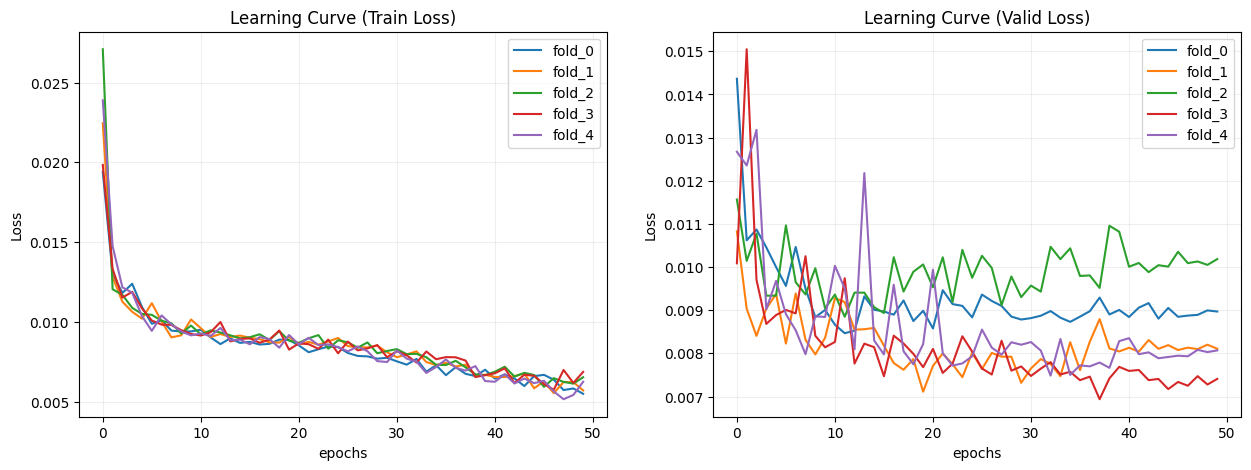

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # 1行2列のサブプロットを作成

for i, his in enumerate(list_history):
    axes[0].plot(his["Train Loss"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画
    axes[1].plot(his["Valid Loss"], label=f"fold_{i}")  # 2つ目のサブプロットにValid Lossを描画

axes[0].set_title("Learning Curve (Train Loss)")
axes[0].set_ylabel("Loss")
axes[0].set_xlabel("epochs")
axes[0].legend()
axes[0].grid(alpha=0.2)
# axes[0].set_ylim([0, 1])

axes[1].set_title("Learning Curve (Valid Loss)")
axes[1].set_ylabel("Loss")
axes[1].set_xlabel("epochs")
axes[1].legend()
axes[1].grid(alpha=0.2)
# axes[1].set_ylim([0, 1])


# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# wandbに記録
# wandb.log({"learning_curve_loss": wandb.Image(img)})

plt.show()

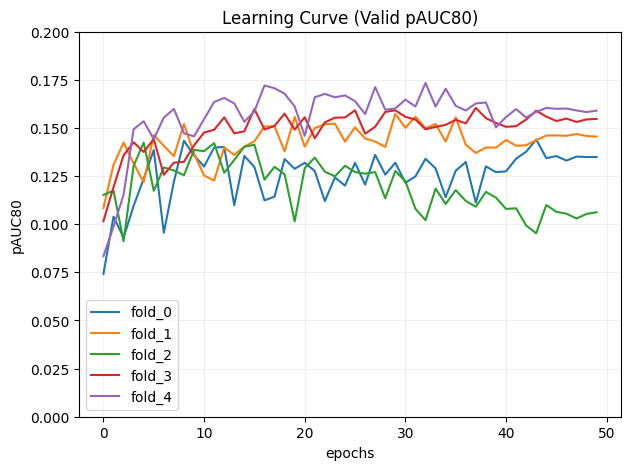

In [30]:
fig, ax = plt.subplots(figsize=(7, 5))  # 1列のサブプロットを作成

for i, his in enumerate(list_history):
    ax.plot(his["Valid AUROC"], label=f"fold_{i}")  # Valid AUROCのみを描画

ax.set_title("Learning Curve (Valid pAUC80)")
ax.set_ylabel("pAUC80")
ax.set_xlabel("epochs")
ax.legend()
ax.grid(alpha=0.2)
ax.set_ylim([0, 0.2])

# PillowのImageオブジェクトに変換
# img = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

# # wandbに記録
# wandb.log({"learning_curve_pAUC80": wandb.Image(img)})

plt.show()

In [31]:
data = [[x, y] for (x, y) in zip(range(len(his["Valid AUROC"].values)), his["Valid AUROC"].values)]
table = wandb.Table(data=data, columns=["x", "y"])
wandb.log(
    {
        "learning_curve_pAUC80": wandb.plot.line(
            table, "x", "y", title="Learning Curve (Valid pAUC80)"
        )
    }
)

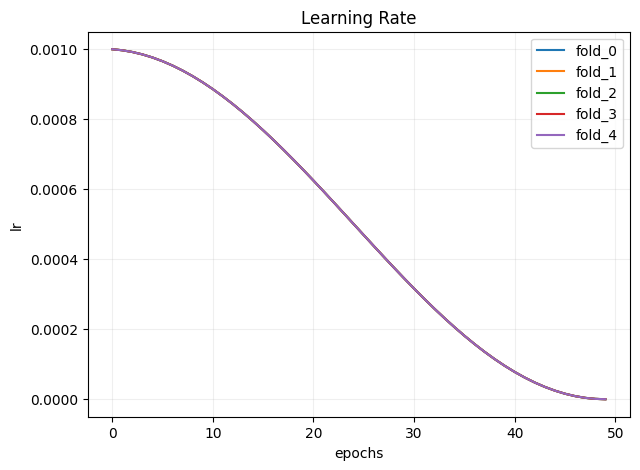

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.grid(alpha=0.2)
for i, his in enumerate(list_history):
    ax.plot(his["lr"], label=f"fold_{i}")  # 1つ目のサブプロットにTrain Lossを描画

ax.set_title("Learning Rate")
ax.set_ylabel("lr")
ax.set_xlabel("epochs")
ax.legend()

plt.show()

In [33]:
pd.options.display.precision = 4

df_pauc = pd.DataFrame(columns=["pAUC80"])
for i, his in enumerate(list_history):
    df_pauc.loc[f"fold_{i}", "pAUC80"] = his["Valid AUROC"].values[-1]

df_pauc.loc["mean", "pAUC80"] = np.mean(df_pauc["pAUC80"])
df_pauc.loc["std", "pAUC80"] = np.std(df_pauc["pAUC80"])
df_pauc

,pAUC80
fold_0,0.1349
fold_1,0.1455
fold_2,0.1062
fold_3,0.1547
fold_4,0.159
mean,0.1401
std,0.0172


In [34]:
if WANDB:
    wandb.log({"pAUC80_fold0": df_pauc.loc["fold_0", "pAUC80"]})
    wandb.log({"pAUC80_fold1": df_pauc.loc["fold_1", "pAUC80"]})
    wandb.log({"pAUC80_fold2": df_pauc.loc["fold_2", "pAUC80"]})
    wandb.log({"pAUC80_fold3": df_pauc.loc["fold_3", "pAUC80"]})
    wandb.log({"pAUC80_fold4": df_pauc.loc["fold_4", "pAUC80"]})
    wandb.log({"pAUC80_mean": df_pauc.loc["mean", "pAUC80"]})

    wandb.finish()

pAUC80_fold0,▁
pAUC80_fold1,▁
pAUC80_fold2,▁
pAUC80_fold3,▁
pAUC80_fold4,▁
pAUC80_mean,▁
pAUC80_fold0,0.1349
pAUC80_fold1,0.14554
pAUC80_fold2,0.10621
pAUC80_fold3,0.15471
pAUC80_fold4,0.15898


In [35]:
# wandb.finish()